# Implementation of learning sine function
Based upon: https://pennylane.ai/blog/2021/10/how-to-start-learning-quantum-machine-learning/

In [1]:
# imports
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Quantum node with only one qubit needed
dev = qml.device("default.qubit", wires=1)

## Construct variational circuit (state_preparation + ansatz)¶

In [3]:
# We use the datapoint as angle for state-preparation
# We have 3 parameters for Rotation -> all states on bloch-sphere can be reached!

@qml.qnode(dev)
def quantum_circuit(datapoint, params):
    # Encode the input data as an RX rotation
    qml.RX(datapoint, wires=0)
    # Create a rotation based on the angles in "params"
    qml.Rot(params[0], params[1], params[2], wires=0)
    # We return the expected value of a measurement along the Z axis
    return qml.expval(qml.PauliZ(wires=0))

## Define loss and accuracy functions needed for optimizing parameters¶

In [4]:
# calculate accuracy with L1-norm
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-2 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

In [5]:
# define function calculating the square mean = ((labels-predictions)**2)/N
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

In [6]:
# first approach: calculate loss by L2-norm
def loss_func(predictions):
    # This is a postprocessing step. Here we use a least squares metric
    # based on the predictions of the quantum circuit and the outputs
    # of the training data points.

    total_losses = 0
    for i in range(len(Y)):
        output = Y[i]
        prediction = predictions[i]
        loss = (prediction - output)**2
        total_losses += loss
    return total_losses

In [7]:
#Define your cost function, including any classical pre/postprocessing
def cost_fn(params):
    # We get the predictions of the quantum circuit for a specific
    # set of parameters along the entire input dataset
    predictions = [quantum_circuit(x, params)  for x in X]
    # We calculate the cost including any classical postprocessing
    #cost = loss_func(predictions)

    # We use the mean(L2) for optimization
    cost = square_loss(Y, predictions)
    return cost

## Load data and initialize parameters and bias

In [8]:
# define number of date points taken for training
num_datapoints = 20

In [9]:
# We create the training Data
X = np.linspace(0, 2*np.pi, num_datapoints) # 20 input datapoints from 0 to 2pi
# We tell the optimizer that this is an input datapoint,
# and not a parameter to optimize over.
X.requires_grad = False
Y = np.sin(X) # The outputs for the input datapoints

# We create the test Data
# 20 test datapoints, shifted from the training data by 0.2
# Since we're not optimizing over the test data we
# don't need to specify requires_grad = False
X_test = np.linspace(0.2, 2*np.pi+0.2, num_datapoints)
Y_test = np.sin(X_test) # The outputs for the test datapoints

In [10]:
params = np.array([0.1,0.1,0.1],requires_grad=True)

## Instantiate Optimizer and start training

In [11]:
opt = qml.GradientDescentOptimizer(stepsize=0.3)

In [12]:
for i in range (200):
    # Over each step the parameters change to give a better cost
    params, prev_cost = opt.step_and_cost(cost_fn,params)
    if i%10 == 0:
         # We print the result after every 10 steps
        print(f'Step = {i} Cost = {cost_fn(params)}')

Step = 0 Cost = 1.0014563288691014
Step = 10 Cost = 0.12341662475058535
Step = 20 Cost = 0.006628055989866391
Step = 30 Cost = 0.0023815506640177306
Step = 40 Cost = 0.0012124088427824
Step = 50 Cost = 0.000732059801102199
Step = 60 Cost = 0.0004893273515655146
Step = 70 Cost = 0.00034992987362083124
Step = 80 Cost = 0.00026258164377325656
Step = 90 Cost = 0.0002042679910707218
Step = 100 Cost = 0.00016341701174667252
Step = 110 Cost = 0.00013369494922210682
Step = 120 Cost = 0.00011139891946917004
Step = 130 Cost = 9.424689275804896e-05
Step = 140 Cost = 8.077041264748418e-05
Step = 150 Cost = 6.998986159001123e-05
Step = 160 Cost = 6.123145406193388e-05
Step = 170 Cost = 5.401943791852994e-05
Step = 180 Cost = 4.801015090735103e-05
Step = 190 Cost = 4.295034091795364e-05


## Evaluate results

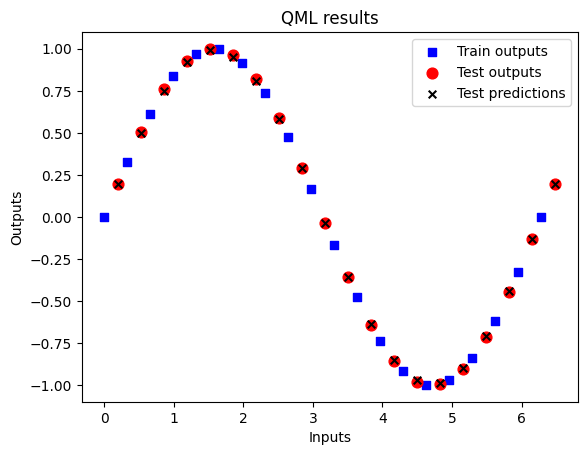

In [13]:
test_predictions = []
for x_test in X_test:
    prediction = quantum_circuit(x_test,params)
    test_predictions.append(prediction)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(X, Y, s=30, c='b', marker="s", label='Train outputs')
ax1.scatter(X_test,Y_test, s=60, c='r', marker="o", label='Test outputs')
ax1.scatter(X_test,test_predictions, s=30, c='k', marker="x", label='Test predictions')
plt.xlabel("Inputs")
plt.ylabel("Outputs")
plt.title("QML results")

plt.legend(loc='upper right');
plt.show()

In [14]:
acc_val = accuracy(Y_test, test_predictions)
print(f"Accuracy: {acc_val}")

Accuracy: 1.0
